In [1]:
%pylab inline
import numpy as np
from tqdm import trange
from collections import OrderedDict
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
# X train data format has 16 rows of header and the images are 28x28 pixels
X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
# Y_train has 8 rows of header
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:] 
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[16:].reshape((-1, 28, 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RickConvNet(nn.Module):
    def __init__(self):
        super(RickConvNet, self).__init__()
        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 32, 3, 1)),
            ('relu1', nn.ReLU()),
            ('maxpool1', nn.MaxPool2d(2)),
            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('relu2', nn.ReLU()),
            ('maxpool2', nn.MaxPool2d(2)),
            ('flatten', nn.Flatten())]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(1600, 128)),
            ('relu3', nn.ReLU()),
            ('fc2', nn.Linear(128,10)),
            ('softmax', nn.LogSoftmax(dim=1))]))

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

loss:0.09 accuracy0.96: 100%|██████████| 1000/1000 [00:06<00:00, 161.84it/s]


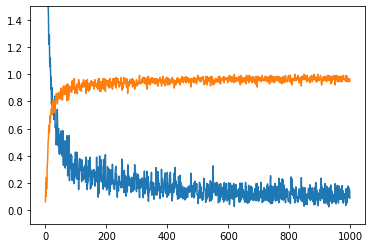

In [6]:
model = RickConvNet().to(device)
model.train()
optim = torch.optim.SGD(model.parameters(), lr=.001)
BS = 128

losses, accs = [], []
for i in (t:= trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[samp].reshape((-1,1,28,28))).float().cuda()
    Y = torch.tensor(Y_train[samp]).long().cuda()
    X.to(device)
    Y.to(device)
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat==Y).float().mean()
    loss = F.nll_loss(out, Y)
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(float(loss))
    accs.append(float(accuracy))
    t.set_description(f'loss:{float(loss):.2f} accuracy{float(accuracy):.2f}')
plt.ylim(-.1, 1.5)
plot(losses)
plot(accs) 

In [7]:
wrong = []
for i in range(X_test.shape[0]):
    X = torch.tensor(X_test[i].reshape(-1,1,28,28)).float().cuda()
    cat = torch.argmax(model(X)).item()
    if cat != Y_test[i].item():
        wrong.append((X_test[i],cat))
test_acc = len(wrong)/len(Y_test)

print(f'{len(wrong)}/{len(Y_test)}: {test_acc:.4f}')

303/10000: 0.0303


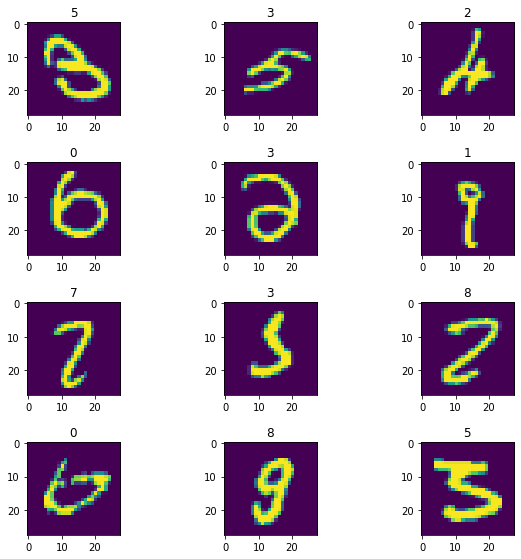

In [8]:
def plot_images_with_titles(images, cols=3):
    rows = len(images) // cols
    fig = plt.figure(figsize=(10, 3*rows))
    ax = []
    for i,el in enumerate(images):
        ax.append(fig.add_subplot(rows+1,cols, i+1))
        plt.imshow(el[0])
        if len(el) > 1:
            ax[-1].set_title(f'{el[1]}')
        fig.subplots_adjust(hspace=0.5)
        
plot_images_with_titles(wrong[:12])

In [9]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()


In [10]:
def plot_weights(model, layer_num, single_channel=True, collated=False):
    layer = model.conv_layers[layer_num]
    print(layer)
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels")

In [ ]:
model.to('cpu')
plot_weights(model, 3)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
